# RAI/USD vs ETH/USD, WIP

Compare RAI/USD and ETH/USD

In [1]:
import os
import time
from decimal import Decimal
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from web3 import Web3, HTTPProvider

from abis import LINK_ETH, LINK_ETH_ABI, LINK_ETH_FIRST_BLOCK
from abis import LINK_RAI, LINK_RAI_ABI, LINK_RAI_FIRST_BLOCK
from abis import ORACLE_RELAYER, ORACLE_RELAYER_ABI, ORACLE_RELAYER_FIRST_BLOCK

from mp import fetch, fetch_link_mp, fetch_rp

size = 15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,12),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}

plt.rcParams.update(params)

In [3]:
# Need an archive node

ETH_RPC_URL=os.environ['ETH_RPC_URL']

web3 = Web3(HTTPProvider(endpoint_uri=ETH_RPC_URL, request_kwargs={"timeout": 10}))

In [4]:
first_block = max(LINK_ETH_FIRST_BLOCK, ORACLE_RELAYER_FIRST_BLOCK)
interval = 6600 * 30
#interval = 275 # 1 hour
num_blocks = None

latest_block = web3.eth.getBlock("latest")['number']

if not num_blocks:
    last_block = latest_block - 12
else:
    last_block = min(latest_block - 12, first_block + num_blocks)

print(f"first block {first_block}, last_block {last_block}")
blocks = list(range(first_block, last_block + 1, interval))

first block 12000000, last_block 15142485


In [5]:
start = time.time()
rp_results = fetch(fetch_rp, 16, ORACLE_RELAYER, ORACLE_RELAYER_ABI, ETH_RPC_URL, blocks=blocks)
print(f"took {time.time() - start}")

took 3.5363080501556396


In [6]:
"""
start = time.time()
rai_results = fetch(fetch_link_mp, 8, LINK_RAI, LINK_RAI_ABI, ETH_RPC_URL, blocks=blocks)
print(f"took {time.time() - start}")
"""

'\nstart = time.time()\nrai_results = fetch(fetch_link_mp, 8, LINK_RAI, LINK_RAI_ABI, ETH_RPC_URL, blocks=blocks)\nprint(f"took {time.time() - start}")\n'

In [7]:
len(rp_results)

16

In [8]:
start = time.time()
eth_results = fetch(fetch_link_mp, 16, LINK_ETH, LINK_ETH_ABI, ETH_RPC_URL, blocks=blocks)
print(f"took {time.time() - start}")

took 3.3099160194396973


In [9]:
rai_df = pd.DataFrame(rp_results, columns = ['block', 'price'])
eth_df = pd.DataFrame(eth_results, columns = ['block', 'price', 'ts', 'started_at'])

In [10]:
rai_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   block   16 non-null     int64 
 1   price   16 non-null     object
dtypes: int64(1), object(1)
memory usage: 384.0+ bytes


In [11]:
rai_df.to_csv('redemption_price_30d_blocks.csv.gz')

In [12]:
eth_df.to_csv('eth_usd_30d_blocks.csv.gz')

Read existing csvs

In [40]:
#rai_df = pd.read_csv('redemption_price_7d_blocks.csv.gz')

In [41]:
#eth_df = pd.read_csv('eth_usd_7d_blocks.csv.gz')

In [42]:
rai_df['price'] = rai_df['price'].astype(float)
eth_df['price'] = eth_df['price'].astype(float)

In [43]:
rai_df['rai_ret'] = rai_df['price'].pct_change()
eth_df['eth_ret'] = eth_df['price'].pct_change()

In [44]:
df = rai_df.merge(eth_df, on='block')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0_x  62 non-null     int64  
 1   block         62 non-null     int64  
 2   price_x       62 non-null     float64
 3   rai_ret       61 non-null     float64
 4   Unnamed: 0_y  62 non-null     int64  
 5   price_y       62 non-null     float64
 6   ts            62 non-null     int64  
 7   started_at    62 non-null     int64  
 8   eth_ret       61 non-null     float64
dtypes: float64(4), int64(5)
memory usage: 4.8 KB


In [46]:
df_final = df[['block', 'rai_ret', 'eth_ret']]

In [47]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   block    62 non-null     int64  
 1   rai_ret  61 non-null     float64
 2   eth_ret  61 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.9 KB


In [48]:
df_final_index = df_final.set_index('block')

<AxesSubplot:title={'center':'Rolling correlation between 30d ETH/USD and 30d Redemption Price returns\n                                      Each point is the correlation between 30d returns for the previous 10 samples'}, xlabel='block'>

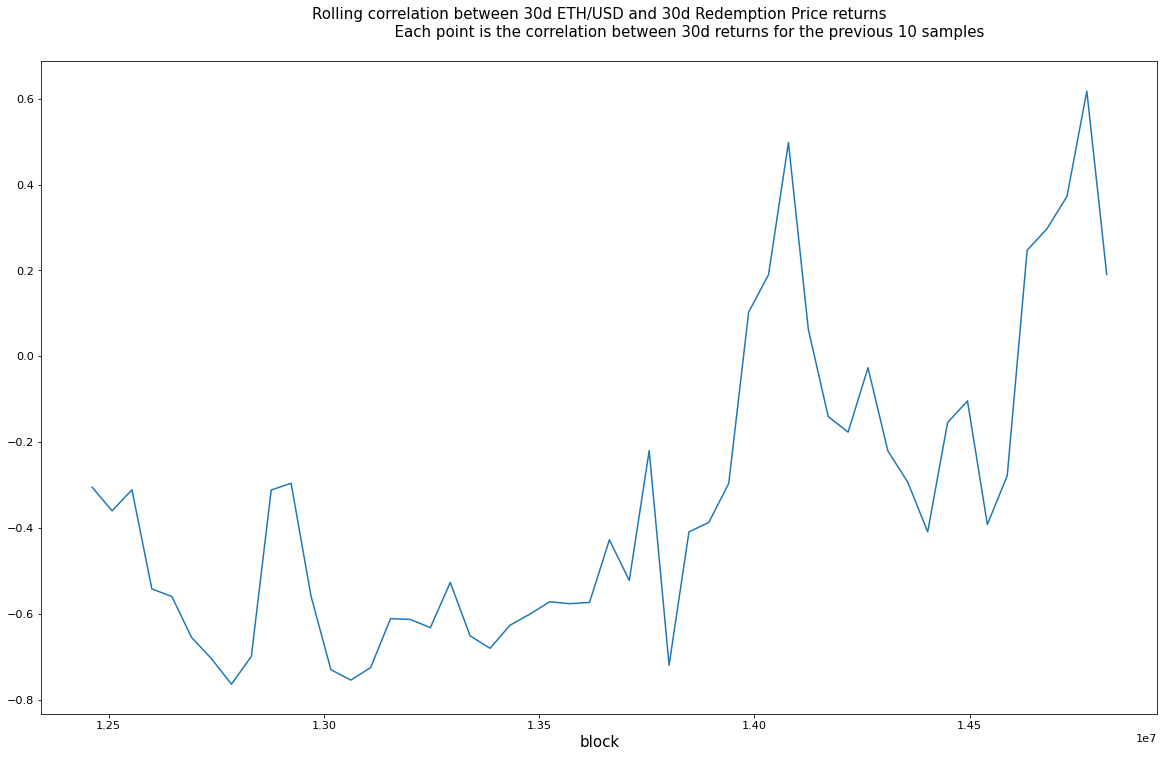

In [57]:
df_final_index['rai_ret'].rolling(10).corr(df_final_index['eth_ret'])\
                        .plot(title='Rolling correlation between 30d ETH/USD and 30d Redemption Price returns\n \
                                     Each point is the correlation between 30d returns for the previous 10 samples')



In [50]:
rai_df['price_norm'] = (rai_df['price'] - min(rai_df['price'])) / (max(rai_df['price']) - min(rai_df['price']))
eth_df['price_norm'] = (eth_df['price'] - min(eth_df['price'])) / (max(eth_df['price']) - min(eth_df['price']))

<AxesSubplot:xlabel='block'>

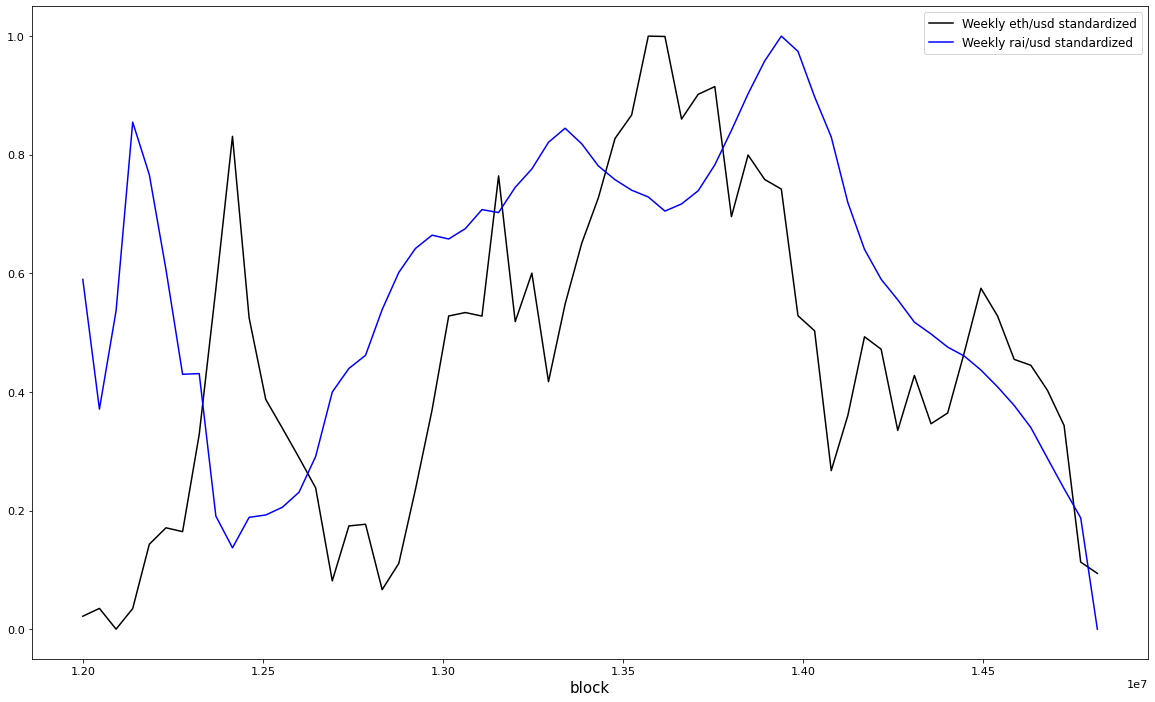

In [51]:
fig, ax = plt.subplots(1,1)
eth_df.plot(y='price_norm', x='block', ax=ax, label='Weekly eth/usd standardized', color='black')
rai_df.plot(y='price_norm', x='block', ax=ax, label='Weekly rai/usd standardized', color='blue')

<AxesSubplot:xlabel='block'>

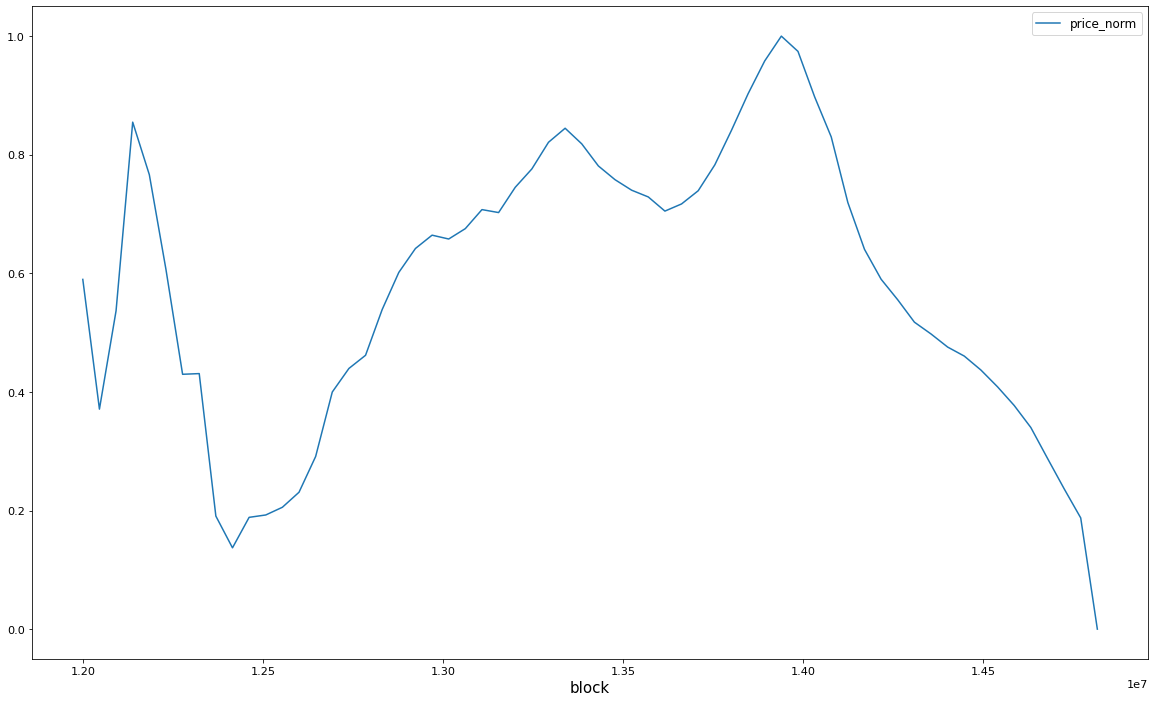

In [52]:
rai_df.plot(y='price_norm', x='block')

In [53]:
'''
# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas

lagged_correlation = pd.DataFrame.from_dict(
    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})
'''

'\n# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas\n\nlagged_correlation = pd.DataFrame.from_dict(\n    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})\n'

In [54]:
df_final_index['rai_ret'].astype(float).corr(df_final_index['eth_ret'].shift(1))

-0.10451302148242117

In [55]:
'''
# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas

lagged_correlation = pd.DataFrame.from_dict(
    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})
'''

'\n# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas\n\nlagged_correlation = pd.DataFrame.from_dict(\n    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag)] for x in df.columns})\n'

In [56]:
max_lag = 168
for x in range(max_lag):
    corr = df_final_index['rai_ret'].iloc[-24*30:].astype(float).corr(df_final_index['eth_ret'].iloc[-24*30:].shift(x))
    print(x, corr)


0 -0.1909900708840701
1 -0.10451302148242117
2 0.003111055529705827
3 0.044286409640780657
4 -0.043923827442414874
5 0.018278143140095227
6 0.18888310095334893
7 0.20435381978352804
8 0.09149860556450498
9 0.11055867758663603
10 0.18290233803799516
11 0.11462161323890654
12 0.1426037498434556
13 -0.030811586963903823
14 -0.1079166022042973
15 0.024027028435731596
16 0.22728267935113264
17 0.18512877082980064
18 0.3143952559242194
19 0.2846348449393095
20 0.3984131626609203
21 0.1100815519170203
22 0.10473453828624292
23 -0.14169266198664543
24 -0.23094813488285085
25 -0.17348282747184857
26 -0.27941707540842414
27 -0.35233680512003773
28 -0.15357279020676712
29 -0.03407666680571183
30 0.03816866605028856
31 0.1741141433440697
32 0.2754156359100602
33 0.5486963880519368
34 0.31943891435570376
35 0.36205401675208493
36 -0.08368606735448868
37 -0.06840671818907743
38 -0.18810902521103354
39 -0.3969288761196571
40 -0.34977586759898643
41 -0.33830928711471236
42 -0.21856661512052794
43 0.16

/Users/georgekellerman/github/reflexer-digital-twin/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/georgekellerman/github/reflexer-digital-twin/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
